In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.utils import normalize
from keras.metrics import MeanIoU
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from keras.optimizers import Adam
import glob
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image_directory ='/content/drive/MyDrive/bolt_data_new/corres_images_rename/'
mask_directory = '/content/drive/MyDrive/bolt_data_new/PixelLabelData_rename/'


image_names = glob.glob('/content/drive/MyDrive/bolt_data_new/corres_images_rename/*.jpg')
image_names.sort()
mask_name = glob.glob('/content/drive/MyDrive/bolt_data_new/PixelLabelData_rename/*.png')
mask_name.sort()

In [ ]:
print(len(mask_name), len(image_names))

1000 1000


In [ ]:
from sklearn.model_selection import train_test_split
#X_train,X_test,y_train,y_test = train_test_split(img_dataset,mask_dataset,test_size=0.20,random_state=12)

In [ ]:
import albumentations as A
l = []
for i, j in zip(image_names, mask_name):
  img = cv2.imread(i)[:,:,::-1]
  l.append(img)

  mask = cv2.imread(j,0)
  l.append(mask)

  transform = A.RandomBrightnessContrast(brightness_limit=(0.1, 0.3), contrast_limit=(0.1, 0.3), p=1.0, always_apply=True)
  RBC = transform(image=img, mask=mask)
  cv2.imwrite(i.split('.')[0]+'_RBC.'+i.split('.')[1], RBC['image'][:,:,::-1])
  cv2.imwrite(j.split('.')[0]+'_RBC.'+j.split('.')[1], RBC['mask'])


  transform = A.HorizontalFlip(p=1.0, always_apply=True)
  HFlip = transform(image=img, mask=mask)
  cv2.imwrite(i.split('.')[0]+'_HFlip.'+i.split('.')[1], HFlip['image'][:,:,::-1])
  cv2.imwrite(j.split('.')[0]+'_HFlip.'+j.split('.')[1], HFlip['mask'])

  transform = A.VerticalFlip(p=1.0, always_apply=True)
  VFlip = transform(image=img, mask=mask)
  cv2.imwrite(i.split('.')[0]+'_VFlip.'+i.split('.')[1], VFlip['image'][:,:,::-1])
  cv2.imwrite(j.split('.')[0]+'_VFlip.'+j.split('.')[1], VFlip['mask'])

  transform = A.VerticalFlip(p=1.0, always_apply=True)
  VHFlip = transform(image=HFlip['image'], mask=HFlip['mask'])
  cv2.imwrite(i.split('.')[0]+'_VHFlip.'+i.split('.')[1], VHFlip['image'][:,:,::-1])
  cv2.imwrite(j.split('.')[0]+'_VHFlip.'+j.split('.')[1], VHFlip['mask'])

  transform = A.Rotate(p=1.0, always_apply=True)
  R = transform(image=img, mask=mask)
  #l.append(R['image'])
  cv2.imwrite(i.split('.')[0]+'_R.'+i.split('.')[1], R['image'][:,:,::-1])
  cv2.imwrite(j.split('.')[0]+'_R.'+j.split('.')[1], R['mask'])


  transform = A.ShiftScaleRotate(p=1.0, always_apply=True)
  SSR = transform(image=img, mask=mask)
  cv2.imwrite(i.split('.')[0]+'_SSR.'+i.split('.')[1], SSR['image'][:,:,::-1])
  cv2.imwrite(j.split('.')[0]+'_SSR.'+j.split('.')[1], SSR['mask'])

  transform = A.ShiftScaleRotate(p=1.0, always_apply=True)
  VHFlipSSR = transform(image=VHFlip['image'], mask=VHFlip['mask'])
  cv2.imwrite(i.split('.')[0]+'_VHFlipSSR.'+i.split('.')[1], VHFlipSSR['image'][:,:,::-1])
  cv2.imwrite(j.split('.')[0]+'_VHFlipSSR.'+j.split('.')[1], VHFlipSSR['mask'])

  transform = A.SafeRotate(p=1.0, always_apply=True)
  SR = transform(image=img, mask=mask)
  cv2.imwrite(i.split('.')[0]+'_RSC.'+i.split('.')[1], SR['image'][:,:,::-1])
  cv2.imwrite(j.split('.')[0]+'_RSC.'+j.split('.')[1], SR['mask'])

  transform = A.SafeRotate(p=1.0, always_apply=True)
  VHFlipSR = transform(image=VHFlip['image'], mask=VHFlip['mask'])
  cv2.imwrite(i.split('.')[0]+'_VHFlipSR.'+i.split('.')[1], VHFlipSR['image'][:,:,::-1])
  cv2.imwrite(j.split('.')[0]+'_VHFlipSR.'+j.split('.')[1], VHFlipSR['mask'])




In [ ]:
print(len())

In [ ]:
aug_images, aug_masks = sorted(glob.glob('/content/drive/MyDrive/bolt_data_new/corres_images_rename/*.jpg')), sorted(glob.glob('/content/drive/MyDrive/bolt_data_new/PixelLabelData_rename/*.png'))
print(len(aug_images),len(aug_masks))

1000 1000


In [ ]:
print(len(aug_images, aug_masks))

TypeError: len() takes exactly one argument (2 given)

In [ ]:
def load_dataset(images, masks):

    train_x, test_x, train_y, test_y = train_test_split(images, masks, test_size=0.25, random_state=360, shuffle=True)
    train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.15, random_state=360, shuffle=True)

    return train_x, val_x, train_y, val_y, test_x, test_y

train_x, val_x, train_y, val_y, test_x, test_y = load_dataset(sorted(aug_images), sorted(aug_masks))
print(len(train_x), len(val_x), len(train_y), len(val_y), len(test_x), len(test_y))

train_X_y_paths = list(zip(train_x, train_y))
val_X_y_paths = list(zip(test_x, test_y))
test_X_y_paths = list(zip(val_x, val_y))

637 113 637 113 250 250


In [ ]:
from google.colab.patches import cv2_imshow

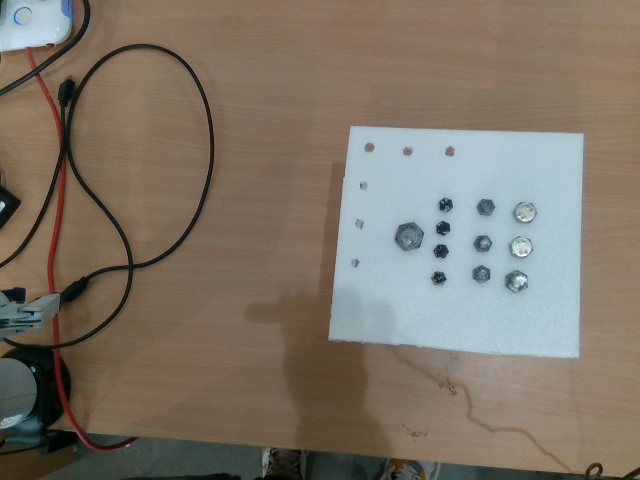

In [ ]:
#print(train_y[5])
cv2_imshow(cv2.imread(test_x[5]))

In [ ]:
def get_data_generator(samples,batch_size):

  while True:

    for offset in range(0, len(samples), batch_size):
      batch_samples = samples[offset:offset+batch_size]
      X_train = []
      Y_train = []

      for batch_sample in batch_samples:

        X_image = cv2.imread(batch_sample[0])[:,:,::-1]
        X_image = X_image / 255.0
        # X_image = cv2.resize(X_image, (256, 256))
        X_image = X_image.astype(np.float32)

        Y_image = cv2.imread(batch_sample[1], 0)
        Y_image = Y_image*255
        # Y_image = Y_image / 255.0
        Y_image = np.where(Y_image>199, 0.0, 1.0)
        # Y_image = cv2.resize(Y_image, (256, 256), fx=0, fy=0, interpolation=cv2.INTER_NEAREST)
        Y_image = tf.one_hot(Y_image, 1, dtype = np.float32)

        X_train.append(X_image)
        Y_train.append(Y_image)


      yield np.array(X_train), np.array(Y_train)

In [ ]:
BATCH_SIZE = 64
train_generator = get_data_generator(train_X_y_paths,batch_size=BATCH_SIZE)
val_generator = get_data_generator(val_X_y_paths,batch_size=BATCH_SIZE)
test_generator = get_data_generator(test_X_y_paths,batch_size=BATCH_SIZE)

In [ ]:
x_train, y_train = next(train_generator)
x_val, y_val  = next(val_generator)
x_test, y_test  = next(test_generator)

print(x_train.shape,y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(64, 480, 640, 3) (64, 480, 640, 1)
(64, 480, 640, 3) (64, 480, 640, 1)
(64, 480, 640, 3) (64, 480, 640, 1)


In [ ]:
print(np.unique(cv2.imread(train_y[5])))

[0 1]


## U-Net


In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    # x = BatchNormalization()(x)   #Not in the original network.
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    # x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 8)
    s2, p2 = encoder_block(p1, 16)
    s3, p3 = encoder_block(p2, 32)

    b1 = conv_block(p3, 64) #Bridge

    d2 = decoder_block(b1, s3, 32)
    d3 = decoder_block(d2, s2, 16)
    d4 = decoder_block(d3, s1, 8)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
input_shape = (480,640,3)
print(input_shape)

(480, 640, 3)


In [ ]:
model = build_unet(input_shape,1)

sigmoid


In [ ]:
from keras import backend as K
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    actual_positives = K.sum(K.round(K.clip(y_true, 0, 1)))

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (actual_positives + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    return f1

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_score])

In [ ]:
train_steps = len(train_x)//BATCH_SIZE
if len(train_x) % BATCH_SIZE != 0:
    train_steps += 1

val_steps = len(val_x)//BATCH_SIZE
if len(val_x) % BATCH_SIZE != 0:
    val_steps += 1



In [ ]:
epochs = 180
h = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=train_steps,
    validation_steps=val_steps,

    batch_size=BATCH_SIZE,
)

Epoch 1/180
10/10 [==============================] - 442s 44s/step - loss: 0.6646 - f1_score: 0.0097 - val_loss: 0.5868 - val_f1_score: 0.0000e+00
Epoch 2/180
10/10 [==============================] - 37s 4s/step - loss: 0.3599 - f1_score: 0.0000e+00 - val_loss: 0.1851 - val_f1_score: 0.0000e+00
Epoch 3/180
10/10 [==============================] - 46s 5s/step - loss: 0.1296 - f1_score: 0.0000e+00 - val_loss: 0.0980 - val_f1_score: 0.0000e+00
Epoch 4/180
10/10 [==============================] - 35s 4s/step - loss: 0.0921 - f1_score: 0.0000e+00 - val_loss: 0.0860 - val_f1_score: 0.0000e+00
Epoch 5/180
10/10 [==============================] - 38s 4s/step - loss: 0.0877 - f1_score: 0.0000e+00 - val_loss: 0.0850 - val_f1_score: 0.0000e+00
Epoch 6/180
10/10 [==============================] - 37s 4s/step - loss: 0.0828 - f1_score: 0.0000e+00 - val_loss: 0.0808 - val_f1_score: 0.0000e+00
Epoch 7/180
10/10 [==============================] - 36s 4s/step - loss: 0.0757 - f1_score: 0.0000e+00 - val

In [ ]:
model.save('first_model.h5')

In [ ]:
import pandas as pd

In [ ]:
history = pd.read_csv('history.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'history.csv'

In [ ]:
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.plot(history['f1-score'], label='train f1-score')
plt.plot(history['val_f1-score'], label='val f1-score')
plt.legend()
plt.show()

plt.plot(history['iou_score'], label='train iou_score')
plt.plot(history['val_iou_score'], label='val iou_score')
plt.legend()
plt.show()

plt.plot(history['lr'], label='LR')
plt.legend()
plt.show()

NameError: name 'model' is not defined

In [ ]:
test_steps = len(test_x)//BATCH_SIZE
if len(test_x) % BATCH_SIZE != 0:
    test_steps += 1

print(test_steps)

model.evaluate(test_generator, batch_size=BATCH_SIZE, steps=test_steps, workers=-1, use_multiprocessing=True)

4
4/4 [==============================] - 16s 2s/step - loss: 0.0045 - f1_score: 0.9398


[0.004513786640018225, 0.9397680163383484]

In [ ]:
print(np.shape(test_x[7]))

()


In [ ]:
test = next(test_generator)[0]
test.shape

(64, 480, 640, 3)

In [ ]:


pred = model.predict(test)
pred.shape

2/2 [==============================] - 7s 45ms/step


(64, 480, 640, 1)

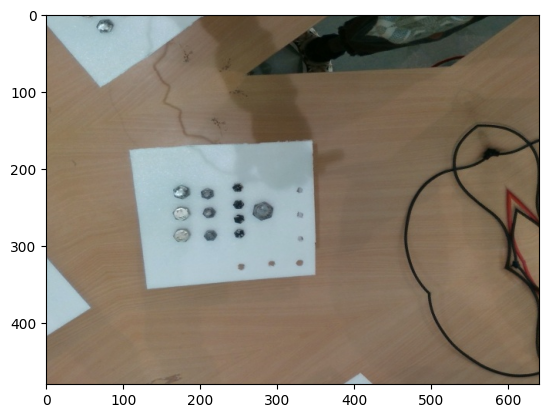

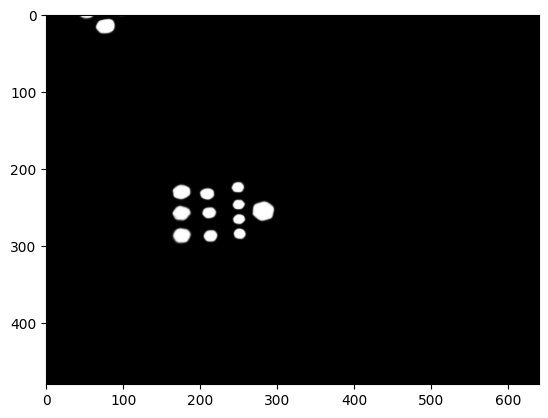

In [ ]:
plt.imshow(test[47])
plt.show()
plt.imshow(pred[47], cmap='gray')

plt.show()

In [ ]:
img = cv2.imread(images[350])[:,:,::-1]/255.0
plt.imshow(img)
plt.show()

mask = cv2.imread(masks[350], 0)
plt.imshow(mask, cmap='gray')
plt.show()

pred = m.predict(img.reshape(1, 240, 320, 3))
print(np.unique(pred))
pred = np.where(pred>=0.5, 0.0, 1.0)
print(np.unique(pred))
# pred = cv2.bitwise_not(pred)
# pred = np.where(pred==-2, 0.0, 1.0)
plt.imshow(pred.reshape(240, 320), cmap='gray')
plt.show()